# Line Fitting

* We wish to fit a line to data where we are given pairs
$$
(y_i, x_i)
$$
for $i=1\dots N$ (or $i=0\dots N-1$)

* Model
$$
f(x; w_1, w_0) = w_0 + w_1 x 
$$


>  $x$ : Input 

>  $w_1$: The slope

>  $w_2$: Intercept

$f_i \equiv f(x_i; w_1, w_0)$


### Example Dataset

Number of registered cars in Turkey, as a function of years.

|$i$|$y_i$|$x_i$|
|-------------|
|Index|Number of Cars (In Millions)|Years from 1995|


In [5]:
%matplotlib inline

import scipy as sc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt

df_arac = pd.read_csv(u'data/arac.csv',sep=';')

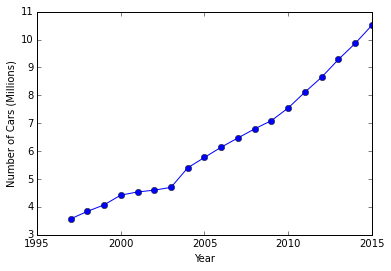

In [6]:
BaseYear = 1995
x = np.matrix(df_arac.Year[31:]).T-BaseYear
y = np.matrix(df_arac.Car[31:]).T/1000000

plt.plot(x+BaseYear, y, 'o-')
plt.xlabel('Year')
plt.ylabel('Number of Cars (Millions)')

plt.show()

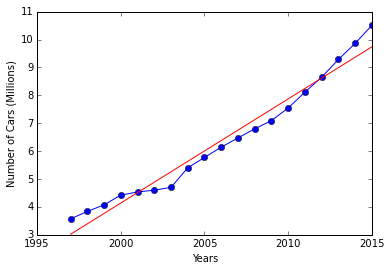

Total Error =  [[ 1.31655621]]


In [7]:

w_0 = 2.27150786
w_1 = 0.37332256

f = w_1*x + w_0
plt.plot(x+BaseYear, y, 'o-')
plt.plot(x+BaseYear, f, 'r')


plt.xlabel('Years')
plt.ylabel('Number of Cars (Millions)')

plt.show()

e = y - f

print('Total Error = ', e.T*e/2)


* Fitting the model: estimating $w = [w_0, w_1]$

* As there is noise, we can't hope to fit our model exactly

* Define the error for each observation 

$$e_i = \frac{1}{2}(y_i - f(x_i; w))^2$$

squared Euclidian norm. The constant $1/2$ is useful for a cosmetical simplification.

* Total Error (sum over all data points)

$$
E(w) = \frac{1}{2} \sum_i (y_i - f(x_i; w))^2
$$

* We can minimize the total error by adjusting $w$

### Visualization of the error surface

A good approach for low dimensional problems is the visualization of the error surface. We evaluate her exhaustively the error for each possible  setting of the parameter $w$. 

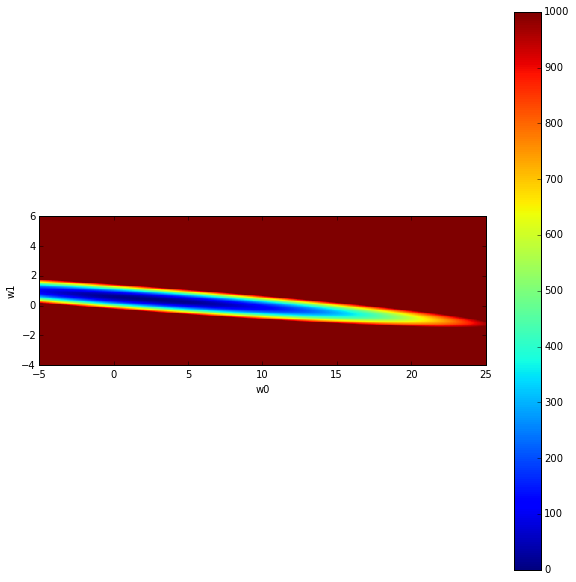

In [8]:
from itertools import product

# Setup the vandermonde matrix
N = len(x)
A = np.hstack((np.ones((N,1)), x))

left = -5
right = 25
bottom = -4
top = 6
step = 0.05
W0 = np.arange(left,right, step)
W1 = np.arange(bottom,top, step)

ErrSurf = np.zeros((len(W1),len(W0)))

for i,j in product(range(len(W1)), range(len(W0))):
    e = y - A*np.matrix([W0[j], W1[i]]).T
    ErrSurf[i,j] = e.T*e/2

plt.figure(figsize=(10,10))
plt.imshow(ErrSurf, interpolation='nearest', 
           vmin=0, vmax=1000,origin='lower',
           extent=(left,right,bottom,top))
plt.xlabel('w0')
plt.ylabel('w1')
plt.colorbar()
plt.show()

## Idea: Least Squares

* Compute the derivative of the total error w.r.t. $w_0$ and $w_1$ and solve the equations

__Derivation comes here__

## Vector Notation

\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{cc}
1 & x_0 \\ 1 & x_1 \\ \vdots \\ 1 & x_{N-1}  
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  
\end{array}
\right)
\end{eqnarray}

\begin{eqnarray}
y \approx A w
\end{eqnarray}

* Error

$e = y - Aw$

\begin{eqnarray}
E(w) & = & \frac{1}{2}e^\top e = \frac{1}{2}(y - Aw)^\top (y - Aw)\\
& = & \frac{1}{2}y^\top y - \frac{1}{2} y^\top Aw - \frac{1}{2} w^\top A^\top y + \frac{1}{2} w^\top A^\top Aw \\
& = & \frac{1}{2} y^\top y - y^\top Aw + \frac{1}{2} w^\top A^\top Aw \\
\end{eqnarray}

* Gradient: Derivative of a function with respect to a vector 
\begin{eqnarray}
\frac{d f}{d w } & = & \left(\begin{array}{c}
 \partial f/\partial w_0 \\ \partial f/\partial w_1 \\ \vdots \\  \partial f/\partial w_{K-1}
\end{array}\right)
\end{eqnarray}

* Gradient of the inner product
\begin{eqnarray}
\frac{d}{d w }(h^\top w) & = & h
\end{eqnarray}

* Gradient of a Quadratic form
\begin{eqnarray}
\frac{d}{d w }(w^\top K w) & = & (K+K^\top) w
\end{eqnarray}
  
* We derive the gradient of the total error as
\begin{eqnarray}
\frac{d}{d w }E(w) & = & \frac{d}{d w }(\frac{1}{2} y^\top y) + \frac{d}{d w }(- y^\top Aw) + \frac{d}{d w }(\frac{1}{2} w^\top A^\top Aw) \\
& = & 0 - A^\top y + A^\top A w = - A^\top (y - Aw) \\
& = & - A^\top e 
& \equiv & \nabla E(w)
\end{eqnarray}

### Least Squares solution: Directly solving the equations 
* Find

\begin{eqnarray}
w^* & = & \arg\min_{w} E(w)
\end{eqnarray}

* Set the derivative to zero and solve for $w^*$

\begin{eqnarray}
0 & = & - A^\top y + A^\top A w^*  \\
A^\top y & = &  A^\top A w^* \\
w^* & = & (A^\top A)^{-1} A^\top y 
\end{eqnarray}

* Projection interpretation:

\begin{eqnarray}
f & = A w^*  = A (A^\top A)^{-1} A^\top y 
\end{eqnarray}

$P$ is the orthogonal projection matrix onto the space spanned by the columns of $A$
\begin{eqnarray}
P & = & A (A^\top A)^{-1} A^\top 
\end{eqnarray}

In [9]:
# Solving the Normal Equations

# Setup the vandermonde matrix
N = len(x)
A = np.hstack((np.ones((N,1)), x))

#plt.imshow(A, interpolation='nearest')
# Solve the least squares problem
w_ls,E,rank,sigma = np.linalg.lstsq(A, y)

print('Parameters: \nw0 = ', w_ls[0],'\nw1 = ', w_ls[1] )
print('Error:', E/2)


Parameters: 
w0 =  [[ 2.28150786]] 
w1 =  [[ 0.37332256]]
Error: [[ 1.31560622]]


### Alternative Solution: Gradient Descent (GD)

* Here, we can iteratively search for better solutions by moving in the negative direction of the gradient

* For solving linear systems, GD is a quite poor algorithm. However, it is applicable to many other problems so it is a good idea to know about it and learn it in this context.

* Iterate until convergence 
\begin{align}
w(0) & = \text{some initial value} \\
\text{for}\;\; & \tau = 1, 2,\dots \\
& w(\tau) = w(\tau-1) - \eta \nabla E(w(\tau-1))
\end{align}

* $\eta$ is the learning rate parameter, to be chosen sufficiently small

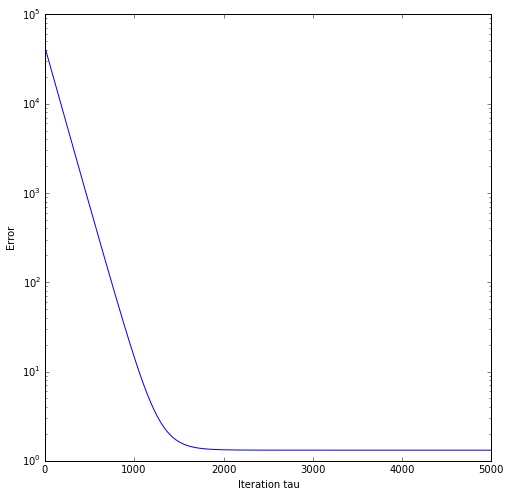

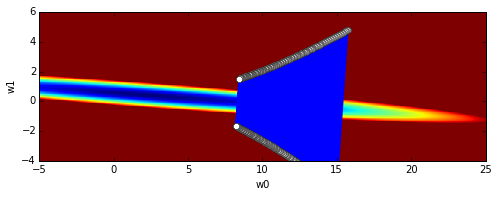

In [13]:
# An implementation of Gradient Descent for solving linear a system

left = -5
right = 25
bottom = -4
top = 6

# Setup the vandermonde matrix
N = len(x)
A = np.hstack((np.ones((N,1)), x))

# Starting point
w = np.matrix('[15; -6]')

# Number of iterations
EPOCH = 5000

# Learning rate: The following is the largest possible fixed rate for this problem
eta = 0.000692

Error = np.zeros((EPOCH))
W = np.zeros((2,EPOCH))

for tau in range(EPOCH):
    # Calculate the error
    e = y - A*w    
    
    # Store the intermediate results
    W[0,tau] = w[0]
    W[1,tau] = w[1]
    Error[tau] = (e.T*e)/2
    
    # Compute the gradient descent step
    g = -A.T*e
    w = w - eta*g

    #print(w.T)
    
w_star = w    
plt.figure(figsize=(8,8))
plt.semilogy(Error)
plt.xlabel('Iteration tau')
plt.ylabel('Error')
plt.show()


plt.figure(figsize=(8,8))
plt.imshow(ErrSurf, interpolation='nearest', 
           vmin=0, vmax=1000,origin='lower',
           extent=(left,right,bottom,top))
plt.xlabel('w0')
plt.ylabel('w1')

ln = plt.Line2D(W[0,:300:1], W[1,:300:1], marker='o',markerfacecolor='w')

plt.gca().add_line(ln)
plt.show()


The illustration shows the convergence of GD with learning rate near the limit where the convergence is oscillatory.

In [ ]:
#f = A*w_ls

f = A*w_star
plt.plot(x+BaseYear, y, 'o-')
plt.plot(x+BaseYear, f, 'r')


plt.xlabel('Years')
plt.ylabel('Number of Cars')

plt.show()

e = y - f

print('Total Error = ', e.T*e/2)

### Analysis of convergence of Gradient descent

Let the gradient be
$\nabla E(w) = g(w)$

We have already derived that
$g(w) = A^\top (Aw - y)$

For constant $\eta$, GD executes the following iteration

$$
w_t = w_{t-1} - \eta g(w_{t-1})
$$


$$
w_t  =  (I - \eta A^\top A) w_{t-1} + \eta A^\top y
$$

This is a fixed point equation of form
$$
w_t  =  T(w_{t-1}) 
$$
where $T$ is an affine transformation. 

We will investigate under which conditions $T$ becomes a contraction, i.e. for two different
parameter $w$ and $w'$

$$
\| T(w) - T(w') \| \leq L_\eta \|w-w' \|
$$

if $L_\eta < 1$, then the distance shrinks. Hence the mapping converges to a fixed point (this is a consequence of a deeper result in analysis called the Brouwer fixed-point theorem (https://en.wikipedia.org/wiki/Brouwer_fixed-point_theorem))

$$
T(w)   =  (I - \eta A^\top A) w + \eta A^\top y
$$
$$
T(w')   =  (I - \eta A^\top A) w' + \eta A^\top y
$$

$$
\| T(w) - T(w') \| = \| (I - \eta A^\top A) (w-w') \| \leq \| I - \eta A^\top A \| \| w-w' \|
$$

When the norm of the matrix $\| I - \eta A^\top A \| < 1$ we have convergence. Here we take the operator norm, i.e., the magnitude of the largest eigenvalue.

Below, we plot the absolute value of the maximum eigenvalues of $I - \eta A^\top A$ as a function of $\eta$.

In [ ]:

left = 0.00001
right = 0.0008
stp = 0.000005

N = 100
ETA = np.linspace(left,right,N)

def compute_largest_eig(ETA, A):
    
    N = len(ETA)
    LAM = np.zeros(N)
    D = A.shape[1]
    
    for i,eta in enumerate(ETA):
        #print(eta)
        lam,v = np.linalg.eig(np.eye(D) - eta*A.T*A)
        LAM[i] = np.max(np.abs(lam))
        
    return LAM

LAM = compute_largest_eig(ETA, A)

plt.plot(ETA, LAM)
plt.plot(ETA, np.ones((N,1)))
plt.gca().set_ylim([0.98, 1.02])
plt.xlabel('eta')
plt.ylabel('absolute value of the largest eigenvalue')
plt.show()



* Note that GD is sensetive to scaling of data
* For example, if we would not have shifted the $x$ axis our original data, GD might not have worked. The maximum eigenvalue is very close to $1$ for all $\eta$ upto numerical precision

In [ ]:
# Try to fit with GD to the original data
BaseYear2 = 0
x2 = np.matrix(df_arac.Year[31:]).T-BaseYear2

# Setup the vandermonde matrix
N = len(x2)
A = np.hstack((np.ones((N,1)), x2))

left = -8
right = -7.55
N = 100
ETA = np.logspace(left,right,N)

LAM = compute_largest_eig(ETA, A)

plt.plot(ETA, LAM)
plt.plot(ETA, np.ones((N,1)))
plt.gca().set_ylim([0.98, 1.02])
plt.xlabel('eta')
plt.ylabel('absolute value of the largest eigenvalue')
plt.show()



## Fitting a polynomial 

### Parabola
\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccc}
1 & x_0 & x_0^2 \\ 1 & x_1 & x_1^2 \\ \vdots \\ 1 & x_{N-1} & x_{N-1}^2   
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  \\ w_2
\end{array}
\right)
\end{eqnarray}

### Polynomial of order $K$
\begin{eqnarray}
\left(
\begin{array}{c}
y_0 \\ y_1 \\ \vdots \\ y_{N-1} 
\end{array}
\right)
\approx
\left(
\begin{array}{ccccc}
1 & x_0 & x_0^2 & \dots & x_0^K \\ 1 & x_1 & x_1^2 & \dots & x_1^K\\ \vdots \\ 1 & x_{N-1} & x_{N-1}^2 & \dots & x_{N-1}^K  
\end{array}
\right) 
\left(
\begin{array}{c}
 w_0 \\ w_1  \\ w_2 \\ \vdots \\ w_K
\end{array}
\right)
\end{eqnarray}


\begin{eqnarray}
y \approx A w
\end{eqnarray}

The solution is identical

In [ ]:
# Setup the vandermonde matrix
N = len(x)
degree = 6
#A = np.hstack((np.power(x,0), np.power(x,1), np.power(x,2)))
A = np.hstack((np.power(x,i) for i in range(degree+1)))
xx = np.matrix(np.linspace(-2,25)).T
A2 = np.hstack((np.power(xx,i) for i in range(degree+1)))

#plt.imshow(A, interpolation='nearest')
# Solve the least squares problem
w_ls,E,rank,sigma = np.linalg.lstsq(A, y)

f = A2*w_ls
plt.plot(x+BaseYear, y, 'o-')
plt.plot(xx+BaseYear, f, 'r')


plt.xlabel('Years')
plt.ylabel('Number of Cars')

plt.show()


# Ignore Cells below

In [ ]:
eta = 0.000346
lam,v = np.linalg.eig(np.eye(2) - eta*2*A.T*A)

lam

A.shape[1]

np.logspace(-8,-5,100)